In [1]:
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob
from scipy.stats import ttest_ind
from treem import Morph, SWC

In [2]:
(SEC_T, SEC_ORDER, SEC_BREADTH, SEC_DIAM, SEC_LEN, SEC_TOTLEN) = range(6)

In [3]:
def load_branchdata(reconstruction):
    m = Morph(reconstruction)
    return [[[sec[0].type(), sec[0].order(), sec[0].breadth(), 
             2*np.mean(m.radii(sec)), m.length(sec), 
             sum([seg.length() for seg in sec[0].walk()])] 
            for sec in stem.sections()] for stem in m.stems()]

In [4]:
mbranch = []
for rec in glob('../data/mouse/derived/sanitized/*.swc'):
    mbranch += load_branchdata(rec)

In [5]:
hbranch = []
for rec in glob('../data/human/derived/sanitized/*.swc'):
        hbranch += load_branchdata(rec)

In [6]:
msec_types = np.array([x[SEC_T] for stem in mbranch for x in stem])
msec_order = np.array([x[SEC_ORDER] for stem in mbranch for x in stem])
msec_breadth = np.array([x[SEC_BREADTH] for stem in mbranch for x in stem])
msec_diam = np.array([x[SEC_DIAM] for stem in mbranch for x in stem])
msec_length = np.array([x[SEC_LEN] for stem in mbranch for x in stem])
msec_totlen = np.array([x[SEC_TOTLEN] for stem in mbranch for x in stem])

In [7]:
hsec_types = np.array([x[SEC_T] for stem in hbranch for x in stem])
hsec_order = np.array([x[SEC_ORDER] for stem in hbranch for x in stem])
hsec_breadth = np.array([x[SEC_BREADTH] for stem in hbranch for x in stem])
hsec_diam = np.array([x[SEC_DIAM] for stem in hbranch for x in stem])
hsec_length = np.array([x[SEC_LEN] for stem in hbranch for x in stem])
hsec_totlen = np.array([x[SEC_TOTLEN] for stem in hbranch for x in stem])

In [8]:
mdend = [x for x in mbranch if x[0][SEC_T]==SWC.DEND]
hdend = [x for x in hbranch if x[0][SEC_T]==SWC.DEND]

In [9]:
Set1 = mpl.colormaps.get_cmap('Set1')
Pastel1 = mpl.colormaps.get_cmap('Pastel1')
mcolor = Set1(0.0)
hcolor = Set1(1.0/9)
mcolor_light = Pastel1(0.0)
hcolor_light = Pastel1(1.0/9)

def p_stars(x, y, pvalues=[0.001, 0.01, 0.05]):
    pv = ttest_ind(x, y).pvalue
    stars = 'n/s'
    if pv < pvalues[0]:
        stars = '***'
    elif pv < pvalues[1]:
        stars = '**'
    elif pv < pvalues[2]:
        stars = '*'
    return stars

In [10]:
def p_value(x, y, method='ttest'):
    pv = None
    if method == 'ttest':
        from scipy.stats import ttest_ind
        pv = ttest_ind(x, y, equal_var=False).pvalue
    elif method == 'lme':
        import pandas as pd
        import statsmodels.api as sm
        import statsmodels.formula.api as smf
        data_x = pd.DataFrame({'value': x, 'sample': 'x', 'group': 'group1'})
        data_y = pd.DataFrame({'value': y, 'sample': 'y', 'group': 'group1'})
        df = pd.concat([data_x, data_y])
        try:
            model = smf.mixedlm("value ~ sample", df, groups=df["group"])
            result = model.fit()
            pv = result.pvalues['sample[T.y]']
        except Exception as e:
            print(f"warning: cannot fit LME model ({e}), returning 'None'")
    else:
        print(f"warning: unknown method '{method}', returning 'None'")
    return pv

def p_stars(pv, pvalues=[0.001, 0.01, 0.05]):
    stars = 'n/s'
    if pv is None:
        stars = '(none)'
    elif pv < pvalues[0]:
        stars = '***'
    elif pv < pvalues[1]:
        stars = '**'
    elif pv < pvalues[2]:
        stars = '*'
    return stars

In [11]:
def plot_boxes(ax, my, hy, ylabel=''):
    mbox = {'facecolor': mcolor, 'linewidth': 3, 'color': mcolor}
    hbox = {'facecolor': hcolor, 'linewidth': 3, 'color': hcolor}
    mwhisk = {'color': mcolor, 'linewidth': 2}
    hwhisk = {'color': hcolor, 'linewidth': 2}
    mcaps={'color': mcolor, 'linewidth': 2}
    hcaps={'color': hcolor, 'linewidth': 2}
    medians={'color': 'white', 'linewidth': 2}
    mfliers = {'marker': 'o', 'markersize': 8, 
               'markerfacecolor': mcolor_light, 'markeredgecolor': 'white', 'zorder': 0}
    hfliers = {'marker': 'o', 'markersize': 8, 
               'markerfacecolor': hcolor_light, 'markeredgecolor': 'white', 'zorder': 0}
    ax.boxplot(my, positions=[1], widths=0.75, patch_artist=True, 
               boxprops=mbox, whiskerprops=mwhisk, capprops=mcaps, medianprops=medians, flierprops=mfliers)
    ax.boxplot(hy, positions=[2], widths=0.75, patch_artist=True, 
               boxprops=hbox, whiskerprops=hwhisk, capprops=hcaps, medianprops=medians, flierprops=hfliers)
    p_ttest = p_value(my, hy, method='ttest')
    p_lme = p_value(my, hy, method='lme')
    pv = p_ttest
    print(f"{ylabel}: {p_ttest=}, {p_lme=}")
    ax.text(0.5, 0.95, p_stars(pv), transform=ax.transAxes, ha='center', fontsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', length=0)
    ax.set_xticklabels(['Mouse', 'Human'], rotation=45, horizontalalignment='right')
    ax.set_ylim(bottom=0, top=1.25*max(max(my), max(hy)))
    ax.set_xlim(0, 3)
    ax.set_xlabel('')

Total length ($\mu$m): p_ttest=0.0002796999135070587, p_lme=1.1094496194747138e-05
Total terminal length ($\mu$m): p_ttest=7.950075730632417e-05, p_lme=1.0868276022412467e-06
Total inner length ($\mu$m): p_ttest=0.8679466129951184, p_lme=0.8566376425381451
Terminal / inner ratio: p_ttest=2.6201493178568392e-06, p_lme=2.0817541432143773e-08
Section length ($\mu$m): p_ttest=1.171234180936821e-14, p_lme=6.121837658934022e-18
Terminal section length ($\mu$m): p_ttest=6.496630020065382e-30, p_lme=1.2883625340290654e-44


/home/akozlov/.local/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/akozlov/.local/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/akozlov/.local/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Inner section length ($\mu$m): p_ttest=0.7941880921900062, p_lme=0.7984459185334263
Section diameter ($\mu$m): p_ttest=4.6082831679402364e-46, p_lme=3.6481929584558853e-69
Maximal distance ($\mu$m): p_ttest=5.643332437903411e-13, p_lme=2.4343354625779015e-28
Maximal path ($\mu$m): p_ttest=5.9946654228093795e-12, p_lme=3.452005575177115e-23
Number of terminals: p_ttest=0.7488919088287083, p_lme=0.7335367525805094
Maximal order: p_ttest=0.8300175184265562, p_lme=0.8296518735102256


/home/akozlov/.local/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


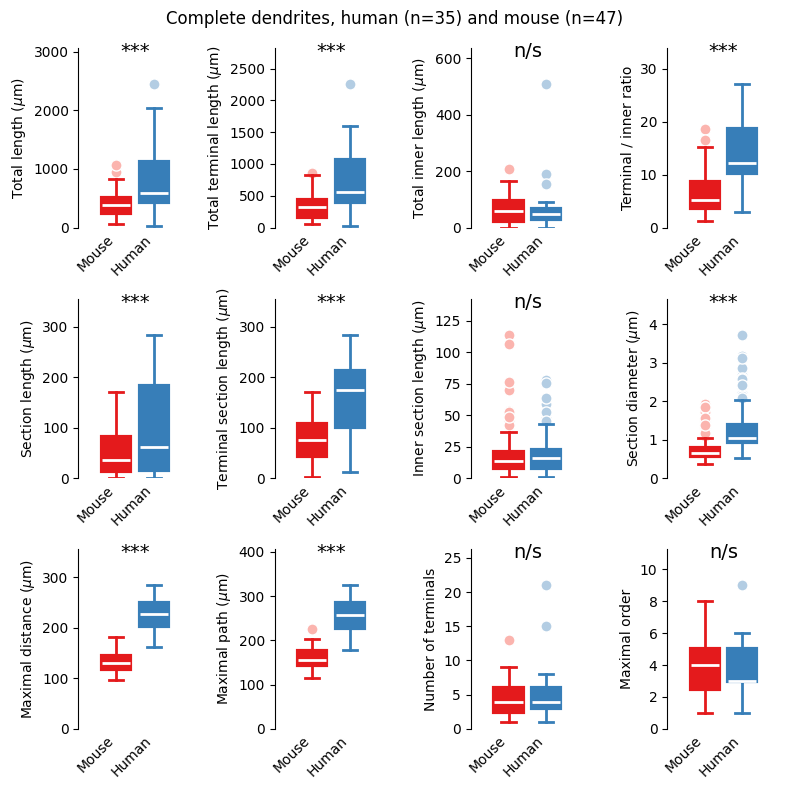

In [12]:
fig = plt.figure(figsize=(8,8))

msel = (msec_types == SWC.DEND) * (msec_order == 1)
mn = len(msec_order[msel])
hsel = (hsec_types == SWC.DEND) * (hsec_order == 1)
hn = len(hsec_order[hsel])
fig.suptitle(f'Complete dendrites, human (n={hn}) and mouse (n={mn})')

ax = fig.add_subplot(3, 4, 1)
msel = (msec_types == SWC.DEND) * (msec_order == 1)
hsel = (hsec_types == SWC.DEND) * (hsec_order == 1)
my = msec_totlen[msel]
hy = hsec_totlen[hsel]
plot_boxes(ax, my, hy, 'Total length ($\mu$m)')

ax = fig.add_subplot(3, 4, 2)
mterm = [sum([x[SEC_LEN] for x in stem if x[SEC_BREADTH]==1]) for stem in mdend]
hterm = [sum([x[SEC_LEN] for x in stem if x[SEC_BREADTH]==1]) for stem in hdend]
my = mterm
hy = hterm
plot_boxes(ax, my, hy, 'Total terminal length ($\mu$m)')

ax = fig.add_subplot(3, 4, 3)
minner = [sum([x[SEC_LEN] for x in stem if x[SEC_BREADTH]!=1]) for stem in mdend]
hinner = [sum([x[SEC_LEN] for x in stem if x[SEC_BREADTH]!=1]) for stem in hdend]
my = minner
hy = hinner
plot_boxes(ax, my, hy, 'Total inner length ($\mu$m)')

ax = fig.add_subplot(3, 4, 4)
my = [x/y for x, y in zip(mterm, minner) if y!=0]
hy = [x/y for x, y in zip(hterm, hinner) if y!=0]
plot_boxes(ax, my, hy, 'Terminal / inner ratio')

ax = fig.add_subplot(3, 4, 5)
msel = (msec_types == SWC.DEND)
hsel = (hsec_types == SWC.DEND)
my = msec_length[msel]
hy = hsec_length[hsel]
plot_boxes(ax, my, hy, 'Section length ($\mu$m)')

ax = fig.add_subplot(3, 4, 6)
msel = (msec_types == SWC.DEND) * (msec_breadth == 1)
hsel = (hsec_types == SWC.DEND) * (hsec_breadth == 1)
my = msec_length[msel]
hy = hsec_length[hsel]
plot_boxes(ax, my, hy, 'Terminal section length ($\mu$m)')

ax = fig.add_subplot(3, 4, 7)
msel = (msec_types == SWC.DEND) * (msec_breadth != 1)
hsel = (hsec_types == SWC.DEND) * (hsec_breadth != 1)
my = msec_length[msel]
hy = hsec_length[hsel]
plot_boxes(ax, my, hy, 'Inner section length ($\mu$m)')

ax = fig.add_subplot(3, 4, 8)
msel = (msec_types == SWC.DEND)
hsel = (hsec_types == SWC.DEND)
my = msec_diam[msel]
hy = hsec_diam[hsel]
plot_boxes(ax, my, hy, 'Section diameter ($\mu$m)')

ax = fig.add_subplot(3, 4, 9)
md = json.load(open('metadata/mouse-sanitized.json'))
hd = json.load(open('metadata/human-sanitized.json'))
my = [md[x]['dend']['dist'] for x in md]
hy = [hd[x]['dend']['dist'] for x in hd]
plot_boxes(ax, my, hy, 'Maximal distance ($\mu$m)')

ax = fig.add_subplot(3, 4, 10)
my = [md[x]['dend']['path'] for x in md]
hy = [hd[x]['dend']['path'] for x in hd]
plot_boxes(ax, my, hy, 'Maximal path ($\mu$m)')

ax = fig.add_subplot(3, 4, 11)
my = [sum([x[SEC_BREADTH] for x in stem if x[SEC_BREADTH]==1]) for stem in mdend]
hy = [sum([x[SEC_BREADTH] for x in stem if x[SEC_BREADTH]==1]) for stem in hdend]
plot_boxes(ax, my, hy, 'Number of terminals')

ax = fig.add_subplot(3, 4, 12)
my = [max([x[SEC_ORDER] for x in stem if x[SEC_BREADTH]==1]) for stem in mdend]
hy = [max([x[SEC_ORDER] for x in stem if x[SEC_BREADTH]==1]) for stem in hdend]
plot_boxes(ax, my, hy, 'Maximal order')

fig.tight_layout()
fig.savefig('images/dend-complete-1.pdf')

In [13]:
mmaxorder = max([max([x[SEC_ORDER] for x in stem if x[SEC_BREADTH]==1]) for stem in mdend])
morders = np.array(range(1, mmaxorder + 1))

In [14]:
mseclen_mean = [np.nanmean([np.mean([x[SEC_LEN] for x in stem if x[SEC_ORDER]==order]) 
                            for stem in mdend]) for order in morders]
mseclen_std = [np.nanstd([np.mean([x[SEC_LEN] for x in stem if x[SEC_ORDER]==order]) 
                          for stem in mdend]) for order in morders]

/home/akozlov/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/akozlov/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
hmaxorder = max([max([x[SEC_ORDER] for x in stem if x[SEC_BREADTH]==1]) for stem in hdend])
horders = np.array(range(1, hmaxorder + 1))

In [16]:
hseclen_mean = [np.nanmean([np.mean([x[SEC_LEN] for x in stem if x[SEC_ORDER]==order]) 
                            for stem in hdend]) for order in horders]
hseclen_std = [np.nanstd([np.mean([x[SEC_LEN] for x in stem if x[SEC_ORDER]==order]) 
                          for stem in hdend]) for order in horders]

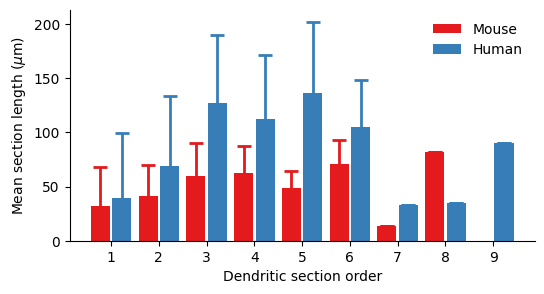

In [17]:
fig, ax = plt.subplots(figsize=(6,3))

ax.bar(morders-0.225, mseclen_mean, yerr=mseclen_std, 
       width=0.4, color=mcolor, label='Mouse',
       error_kw={'ecolor': mcolor, 'linewidth': 2, 'capsize': 5, 'capthick':2})
ax.bar(horders+0.225, hseclen_mean, yerr=hseclen_std, 
       width=0.4, color=hcolor, label='Human',
       error_kw={'ecolor': hcolor, 'linewidth': 2, 'capsize': 5, 'capthick':2})
ax.set_ylim(bottom=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(horders)
ax.set_xlabel('Dendritic section order')
ax.set_ylabel('Mean section length ($\mu$m)')
ax.legend(frameon=False)
fig.savefig('images/dend-complete-2.pdf')

In [18]:
mmean = np.array(mseclen_mean)
mstd = np.array(mseclen_std)
msel = mstd != 0.0

In [19]:
hmean = np.array(hseclen_mean)
hstd = np.array(hseclen_std)
hsel = hstd != 0.0

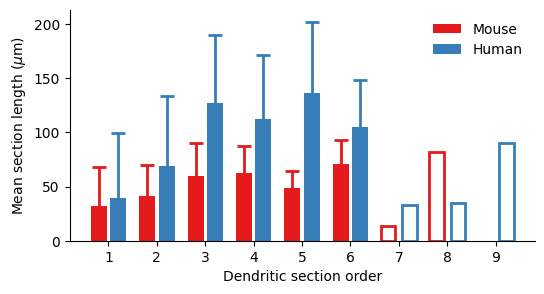

In [20]:
fig, ax = plt.subplots(figsize=(6,3))

ax.bar(morders[msel]-0.2, mmean[msel], yerr=mstd[msel], 
       width=0.33, color=mcolor, label='Mouse',
       error_kw={'ecolor': mcolor, 'linewidth': 2, 'capsize': 5, 'capthick':2})
ax.bar(morders[~msel]-0.22, mmean[~msel], 
       width=0.3, color='white', edgecolor=mcolor, linewidth=2)

ax.bar(horders[hsel]+0.2, hmean[hsel], yerr=hstd[hsel], 
       width=0.33, color=hcolor, label='Human',
       error_kw={'ecolor': hcolor, 'linewidth': 2, 'capsize': 5, 'capthick':2})
ax.bar(horders[~hsel]+0.22, hmean[~hsel], 
       width=0.3, color='white', edgecolor=hcolor, linewidth=2)

ax.set_ylim(bottom=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(horders)
ax.set_xlabel('Dendritic section order')
ax.set_ylabel('Mean section length ($\mu$m)')
ax.legend(frameon=False)
fig.savefig('images/dend-complete-3.pdf')

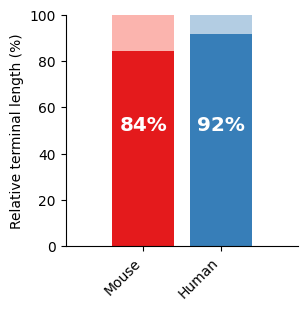

In [21]:
fig, ax = plt.subplots(figsize=(3,3))

mterm = [sum([x[SEC_LEN] for x in stem if x[SEC_BREADTH]==1]) for stem in mdend]
hterm = [sum([x[SEC_LEN] for x in stem if x[SEC_BREADTH]==1]) for stem in hdend]
mall = [sum([x[SEC_LEN] for x in stem]) for stem in mdend]
hall = [sum([x[SEC_LEN] for x in stem]) for stem in hdend]
mrel = sum(mterm) / sum(mall) * 100
hrel = sum(hterm) / sum(hall) * 100

ax.bar([1], [100], color=mcolor_light)
ax.bar([1], [mrel], color=mcolor)
ax.bar([2], [100], color=hcolor_light)
ax.bar([2], [hrel], color=hcolor)

ax.text(1, 50, f'{mrel:.0f}%', ha='center', fontsize='x-large', fontweight='bold', color='w')
ax.text(2, 50, f'{hrel:.0f}%', ha='center', fontsize='x-large', fontweight='bold', color='w')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Mouse', 'Human'], rotation=45, horizontalalignment='right')
ax.set_ylabel('Relative terminal length (%)')
ax.set_ylim(0, 100)
ax.set_xlim(0, 3)
fig.savefig('images/dend-complete-4.pdf')

Total length ($\mu$m): p_ttest=0.0002796999135070587, p_lme=1.1094496194747138e-05
Total terminal length ($\mu$m): p_ttest=7.950075730632417e-05, p_lme=1.0868276022412467e-06
Number of terminals: p_ttest=0.7488919088287083, p_lme=0.7335367525805094
Maximal order: p_ttest=0.8300175184265562, p_lme=0.8296518735102256
Section length ($\mu$m): p_ttest=1.171234180936821e-14, p_lme=6.121837658934022e-18
Terminal section length ($\mu$m): p_ttest=6.496630020065382e-30, p_lme=1.2883625340290654e-44
Maximal distance to soma ($\mu$m): p_ttest=5.643332437903411e-13, p_lme=2.4343354625779015e-28


/home/akozlov/.local/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/akozlov/.local/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Section diameter ($\mu$m): p_ttest=4.6082831679402364e-46, p_lme=3.6481929584558853e-69


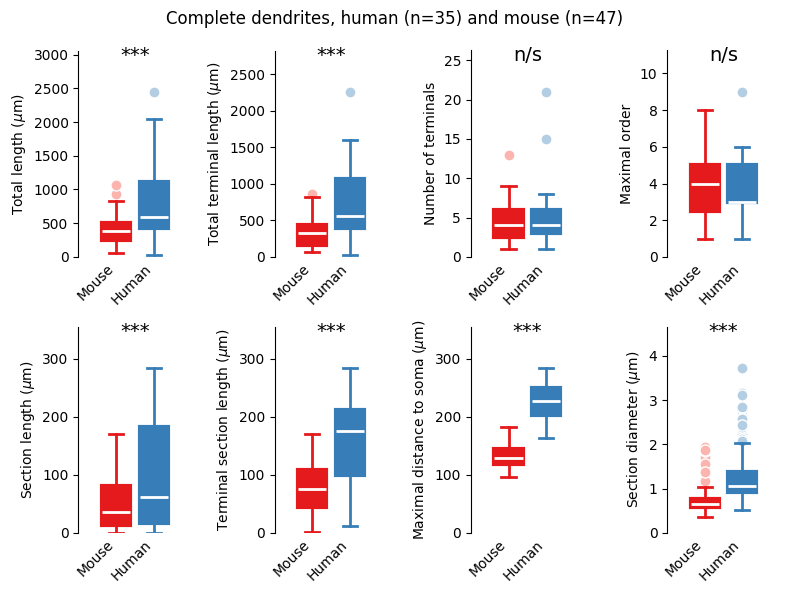

In [22]:
fig = plt.figure(figsize=(8,6))

msel = (msec_types == SWC.DEND) * (msec_order == 1)
mn = len(msec_order[msel])
hsel = (hsec_types == SWC.DEND) * (hsec_order == 1)
hn = len(hsec_order[hsel])
fig.suptitle(f'Complete dendrites, human (n={hn}) and mouse (n={mn})')

ax = fig.add_subplot(2, 4, 1)
msel = (msec_types == SWC.DEND) * (msec_order == 1)
hsel = (hsec_types == SWC.DEND) * (hsec_order == 1)
my = msec_totlen[msel]
hy = hsec_totlen[hsel]
plot_boxes(ax, my, hy, 'Total length ($\mu$m)')

ax = fig.add_subplot(2, 4, 2)
mterm = [sum([x[SEC_LEN] for x in stem if x[SEC_BREADTH]==1]) for stem in mdend]
hterm = [sum([x[SEC_LEN] for x in stem if x[SEC_BREADTH]==1]) for stem in hdend]
my = mterm
hy = hterm
plot_boxes(ax, my, hy, 'Total terminal length ($\mu$m)')

ax = fig.add_subplot(2, 4, 3)
my = [sum([x[SEC_BREADTH] for x in stem if x[SEC_BREADTH]==1]) for stem in mdend]
hy = [sum([x[SEC_BREADTH] for x in stem if x[SEC_BREADTH]==1]) for stem in hdend]
plot_boxes(ax, my, hy, 'Number of terminals')

ax = fig.add_subplot(2, 4, 4)
my = [max([x[SEC_ORDER] for x in stem if x[SEC_BREADTH]==1]) for stem in mdend]
hy = [max([x[SEC_ORDER] for x in stem if x[SEC_BREADTH]==1]) for stem in hdend]
plot_boxes(ax, my, hy, 'Maximal order')

ax = fig.add_subplot(2, 4, 5)
msel = (msec_types == SWC.DEND)
hsel = (hsec_types == SWC.DEND)
my = msec_length[msel]
hy = hsec_length[hsel]
plot_boxes(ax, my, hy, 'Section length ($\mu$m)')

ax = fig.add_subplot(2, 4, 6)
msel = (msec_types == SWC.DEND) * (msec_breadth == 1)
hsel = (hsec_types == SWC.DEND) * (hsec_breadth == 1)
my = msec_length[msel]
hy = hsec_length[hsel]
plot_boxes(ax, my, hy, 'Terminal section length ($\mu$m)')

ax = fig.add_subplot(2, 4, 7)
md = json.load(open('metadata/mouse-sanitized.json'))
hd = json.load(open('metadata/human-sanitized.json'))
my = [md[x]['dend']['dist'] for x in md]
hy = [hd[x]['dend']['dist'] for x in hd]
plot_boxes(ax, my, hy, 'Maximal distance to soma ($\mu$m)')

ax = fig.add_subplot(2, 4, 8)
msel = (msec_types == SWC.DEND)
hsel = (hsec_types == SWC.DEND)
my = msec_diam[msel]
hy = hsec_diam[hsel]
plot_boxes(ax, my, hy, 'Section diameter ($\mu$m)')

fig.tight_layout()
fig.savefig('images/dend-complete-5.pdf')